In [1]:
import numpy as np
import lal
import lalsimulation as lalsim
#import pycbc
import h5py
from lal import MSUN_SI, PC_SI, PI
#%matplotlib inline
import matplotlib
import matplotlib.pyplot as P
import pycbc.types, pycbc.filter

import os, glob
import shutil as sh
import lalsimulation as lalsim
%matplotlib inline

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/h5py-2.7.0-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
os.environ["LAL_DATA_PATH"] = "/home/daniel/data/gravitational-waves/lal-data/"

In [3]:
def set_mode_in_params(params, l, m):
    """ Sets modes in params dict.
        Only adds (l,m) and (l,-m) modes.
    """

    ma=lalsim.SimInspiralCreateModeArray()

    lalsim.SimInspiralModeArrayActivateMode(ma, l, m)
    lalsim.SimInspiralModeArrayActivateMode(ma, l, -m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(params, ma)
    return params


In [4]:
def load_lvcnr_data(NRh5File, mode):
    """ Loads only (l,m) and (l,-m) modes of lvcnr data
    """

    # set mode for NR data
    params_NR = lal.CreateDict()
    lalsim.SimInspiralWaveformParamsInsertNumRelData(params_NR, filepath)
    params_NR = set_mode_in_params(params_NR, mode[0], mode[1])
    mtotal = 100.
    deltaT = 1./4096. #1.0/8192.
    m1 = NRh5File.attrs['mass1']
    m2 = NRh5File.attrs['mass2']
    m1SI = m1 * mtotal/(m1 + m2) * MSUN_SI #Assumes masses are irreducible masses
    m2SI = m2 * mtotal/(m1 + m2) * MSUN_SI

    # This will use the entire data
    f_lower = 0

    inclination = 0
    distance = 100. * PC_SI * 1.0e6
    phiRef = 0.0
    fRef = f_lower
    spins = lalsim.SimInspiralNRWaveformGetSpinsFromHDF5File(fRef, mtotal, filepath)
    s1x = spins[0]
    s1y = spins[1]
    s1z = spins[2]
    s2x = spins[3]
    s2y = spins[4]
    s2z = spins[5]

    
    # If f_lower == 0, update it to the start frequency so that SEOBNRv4 gets the right start
    # frequency
    if f_lower == 0:
        f_lower = NRh5File.attrs['f_lower_at_1MSUN']/mtotal
    fRef = f_lower
    fStart = fRef
    approx = lalsim.NR_hdf5
    hp, hc = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z, s2x, s2y, s2z, distance, inclination, phiRef, 0.0, 0.0, 0.0, deltaT, fStart, fRef, params_NR, approx)
    times = np.arange(len(hp.data.data))*hp.deltaT
    return times, hp, hc, mtotal, m1SI, m2SI, s1x, s1y, s1z, s2x, s2y, s2z, distance, inclination, phiRef, deltaT, fStart, fRef



In [5]:
def shift_peak_to_zero(t, hp, hc):
    h = hp.data.data -1j * hc.data.data
    peakIdx = np.argmax(np.abs(h))
    t -= t[peakIdx]
    return t, h

#Extract the metadata from h5 
def read_flow(h5path_new):
    
    h5file = h5py.File(h5path_new)

    for item in h5file.attrs.keys():
        if (item=='f_lower_at_1MSUN'):
            return h5file.attrs[item]

In [6]:
waveform = "GT0370"
msun = 1.989e30

In [7]:
#lvcnr_file = sorted(glob.glob('/home/bhavesh.khamesra/Data/TestWaveforms/WaveformFiles/NonSpinning/%s.h5'%waveform))
lvcnr_file = sorted(glob.glob('/home/daniel/data-nosync/lvcnr-lfs/GeorgiaTech/%s.h5'%waveform))

if (len(lvcnr_file)==0): raise ValueError("Waveform %s not found. Please check the path"%waveform)

In [8]:
testdir = "/home/daniel/tmp"

In [9]:
if not(os.path.exists(testdir)):
    os.makedirs(testdir)
    
# Path where h5files will be copied 
h5dirpath = testdir + '/H5Files/'
if not(os.path.exists(h5dirpath)):
    os.makedirs(h5dirpath)
    
#Copy the h5file to the h5directory in test directory
h5path_new = h5dirpath+ waveform+'.h5'
if os.path.exists(h5path_new):
    os.remove(h5path_new)
    
if os.path.exists(lvcnr_file[0]):
    sh.copyfile(lvcnr_file[0], h5path_new)
else:
    print('%s waveform not found'%os.path.basename(waveform))
    
h5files = [h5path_new]

In [10]:
for filepath in h5files:

    NRh5File = h5py.File(filepath, 'r')
    t_NR, hp_NR, hc_NR, mtotal, m1SI, m2SI, s1x, s1y, s1z, s2x, s2y, s2z, distance, inclination, phiRef, deltaT, fStart, fRef = load_lvcnr_data(NRh5File, [2,2])
    NRh5File.close()
    flow_metadata = read_flow(filepath)
    print("Waveform Details: \n")
    print(" m1 = %g Msun, m2 = %g Msun, q = %g\n s1 = (%g, %g, %g) \n s2 = (%g, %g, %g) \n distance=%g, inclination = %g, phiref = %g \n"%(m1SI/msun, m2SI/msun, m1SI/m2SI, s1x, s1y, s1z, s2x, s2y, s2z, distance, inclination, phiRef))

    t_NR, h_NR = shift_peak_to_zero(t_NR, hp_NR, hc_NR)
    phi22_NR = np.unwrap(np.angle(h_NR))


    omega22_NR = np.gradient(phi22_NR)/np.gradient(t_NR)
    flow_NR = -1.*omega22_NR[0]/2/np.pi
    print('%s:frequency comupted from (2,2)mode = %g, from NR metadata = %g, diff = %g'% (os.path.basename(filepath),flow_NR, fStart,  -flow_NR + fStart))



Waveform Details: 

 m1 = 53.4762 Msun, m2 = 46.501 Msun, q = 1.15
 s1 = (0, 0, 0) 
 s2 = (0, 0, 0) 
 distance=3.08568e+24, inclination = 0, phiref = 0 

GT0370.h5:frequency comupted from (2,2)mode = 18.055, from NR metadata = 19.3307, diff = 1.27569


In [11]:
# choose waveform model to compare aginst lvcnr
waveform_model1 = 'SEOBNRv4'

# Generate the waveform with the same parameters as lvcnr, including the same start frequency
params_seob = lal.CreateDict()
approx_seob = lalsim.GetApproximantFromString(waveform_model1)

#change this for better overlap
phiRef_seob =0. 

hp_seob, hc_seob = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z,
    s2x, s2y, s2z, distance, inclination, phiRef_seob, 0.0, 0.0, 0.0,
    deltaT, fStart, fRef, params_seob, approx_seob)
t_seob = np.arange(len(hp_seob.data.data))*hp_seob.deltaT

# shift time array such that peak occurs at t=0
t_seob, h_seob = shift_peak_to_zero(t_seob, hp_seob, hc_seob)



waveform_model2 = 'IMRPhenomPv2'

# Generate the waveform with the same parameters as lvcnr, including the same start frequency
params_ph = lal.CreateDict()
approx_ph = lalsim.GetApproximantFromString(waveform_model2)

#change this for better overlap
phiRef_ph = 1.4

hp_ph, hc_ph = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z,
    s2x, s2y, s2z, distance, inclination, phiRef_ph, 0.0, 0.0, 0.0,
    deltaT, fStart, fRef, params_ph, approx_ph)
t_ph = np.arange(len(hp_ph.data.data))*hp_ph.deltaT

# shift time array such that peak occurs at t=0
t_ph, h_ph = shift_peak_to_zero(t_ph, hp_ph, hc_ph)


In [12]:
#Make the length of waveforms equal:
wf_NR_maxidx = np.argmax(np.absolute(h_NR))
NR_fwd_tlen = len(h_NR.real[wf_NR_maxidx:])
NR_bwd_tlen = len(h_NR.real[:wf_NR_maxidx])

wf_seob_maxidx = np.argmax(np.absolute(h_seob))
seob_fwd_tlen = len(h_seob.real[wf_seob_maxidx:])
seob_bwd_tlen = len(h_seob.real[:wf_seob_maxidx])

if NR_fwd_tlen>seob_fwd_tlen:
    wf_NR_fwd = h_NR.real[wf_NR_maxidx:wf_NR_maxidx+seob_fwd_tlen]
    wf_seob_fwd = h_seob.real[wf_seob_maxidx:seob_fwd_tlen+wf_seob_maxidx]
    t_seob_fwd = t_seob[wf_seob_maxidx:seob_fwd_tlen+wf_seob_maxidx]
else:
    wf_NR_fwd = h_NR.real[wf_NR_maxidx:NR_fwd_tlen+wf_NR_maxidx]
    wf_seob_fwd = h_seob.real[wf_seob_maxidx:NR_fwd_tlen+wf_seob_maxidx]
    t_seob_fwd = t_seob[wf_seob_maxidx:NR_fwd_tlen+wf_seob_maxidx]


if NR_bwd_tlen>seob_bwd_tlen:
    diff = NR_bwd_tlen - seob_bwd_tlen
    wf_NR_bwd = h_NR.real[diff:wf_NR_maxidx]
    wf_seob_bwd = h_seob.real[0:wf_seob_maxidx]
    t_seob_bwd = t_seob[0:wf_seob_maxidx]
else:
    diff = abs(NR_bwd_tlen - seob_bwd_tlen)
    wf_NR_bwd = h_NR.real[0:wf_NR_maxidx]
    wf_seob_bwd = h_seob.real[diff:wf_seob_maxidx]
    t_seob_bwd = t_seob[diff:wf_seob_maxidx]


wf_NR = np.append(wf_NR_bwd, wf_NR_fwd)
wf_seob = np.append(wf_seob_bwd, wf_seob_fwd)
time_seob = np.append(t_seob_bwd, t_seob_fwd)


wf_nr_data = pycbc.types.TimeSeries(wf_NR, deltaT)              #hp_NR.data.data, deltaT)
wf_seob_data = pycbc.types.TimeSeries(wf_seob, deltaT)          #hplus_seob, deltaT)
#wf_phenom_data = pycbc.types.TimeSeries(hp_ph.data.data, deltaT)


print("Match between NR and SEOBNR = {}".format( pycbc.filter.match(wf_nr_data, wf_seob_data)))


creating /tmp/weave-daniel-Ko0Uqa/python27_intermediate/compiler_3621272828118ea3beee9cf268575d7a
Match between NR and SEOBNR = (0.993528510775718, 1)


In [13]:
#P.plot(time_seob, wf_NR, label='NR')
#P.plot(time_seob, wf_seob, label='SEOB')
#P.xlabel('Time')
#P.ylabel('h+')
#P.xlim(-0.1,0.1)
#P.legend()
#P.savefig(figdir+'testfig.png')
#P.close()


#Make the length of waveforms equal:
wf_NR_maxidx = np.argmax(np.absolute(h_NR))
NR_fwd_tlen = len(h_NR.real[wf_NR_maxidx:])
NR_bwd_tlen = len(h_NR.real[:wf_NR_maxidx])

wf_ph_maxidx = np.argmax(np.absolute(h_ph))
ph_fwd_tlen = len(h_ph.real[wf_ph_maxidx:])
ph_bwd_tlen = len(h_ph.real[:wf_ph_maxidx])

if NR_fwd_tlen>ph_fwd_tlen:
    wf_NR_fwd = h_NR.real[wf_NR_maxidx:wf_NR_maxidx+ph_fwd_tlen]
    wf_ph_fwd = h_ph.real[wf_ph_maxidx:ph_fwd_tlen+wf_ph_maxidx]
    t_ph_fwd = t_ph[wf_ph_maxidx:ph_fwd_tlen+wf_ph_maxidx]
else:
    wf_NR_fwd = h_NR.real[wf_NR_maxidx:NR_fwd_tlen+wf_NR_maxidx]
    wf_ph_fwd = h_ph.real[wf_ph_maxidx:NR_fwd_tlen+wf_ph_maxidx]
    t_ph_fwd = t_ph[wf_ph_maxidx:NR_fwd_tlen+wf_ph_maxidx]


if NR_bwd_tlen>ph_bwd_tlen:
    diff = NR_bwd_tlen - ph_bwd_tlen
    wf_NR_bwd = h_NR.real[diff:wf_NR_maxidx]
    wf_ph_bwd = h_ph.real[0:wf_ph_maxidx]
    t_ph_bwd = t_ph[0:wf_ph_maxidx]
else:
    diff = abs(NR_bwd_tlen - ph_bwd_tlen)
    wf_NR_bwd = h_NR.real[0:wf_NR_maxidx]
    wf_ph_bwd = h_ph.real[diff:wf_ph_maxidx]
    t_ph_bwd = t_ph[diff:wf_ph_maxidx]


In [14]:
wf_NR = np.append(wf_NR_bwd, wf_NR_fwd)
wf_ph = np.append(wf_ph_bwd, wf_ph_fwd)
time_ph = np.append(t_ph_bwd, t_ph_fwd)


wf_nr_data = pycbc.types.TimeSeries(wf_NR, deltaT)              #hp_NR.data.data, deltaT)
wf_ph_data = pycbc.types.TimeSeries(wf_ph, deltaT)              #hplus_ph, deltaT)
#wf_phenom_data = pycbc.types.TimeSeries(hp_ph.data.data, deltaT)


print("Match between NR and IMR-Phenom v2 = {}".format(pycbc.filter.match(wf_nr_data, wf_ph_data)))
figdir = "/home/bhavesh.khamesra/public_html/GTWaveforms_Checks/"

P.plot(time_ph, wf_NR, label='NR')
P.plot(time_ph, wf_ph, label='PhenomP')
P.xlabel('Time')
P.ylabel('h+')
P.xlim(-0.1,0.1)
P.legend()
#P.savefig(figdir+'testfig2.png')
P.close()



Match between NR and IMR-Phenom v2 = (0.9910823392629353, 2279)


/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u"'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


IOError: [Errno 2] No such file or directory: '/home/bhavesh.khamesra/public_html/GTWaveforms_Checks/Strain_GT0370_real.png'

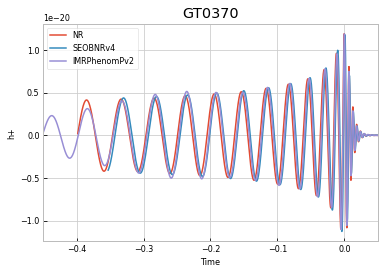

In [15]:
# much better now (although still not perfect)
P.figure()
P.plot(t_NR, h_NR.real, label='NR')
P.plot(t_seob, h_seob.real, label=waveform_model1)
P.plot(t_ph, h_ph.real, label=waveform_model2)
P.xlim(-0.45,0.05)
P.xlabel('Time')
P.ylabel('h+')
P.title(waveform)
P.grid(True)
P.legend()
P.savefig(figdir+'Strain_%s_real.png'%waveform)
P.close()


P.figure()
P.plot(t_NR, h_NR.real, label='NR')
P.plot(t_seob, h_seob.real, label=waveform_model1)
P.plot(t_ph, h_ph.real, label=waveform_model2)
P.xlabel('Time')
P.ylabel('h+')
#P.xlim(-0.1,0.05)
P.grid(True)
P.title(waveform)
P.legend()
P.savefig(figdir+'Strain_%s_real_zoom.png'%waveform)
P.close()


P.figure()
P.plot(t_NR, h_NR.imag, label='NR')
P.plot(t_seob, h_seob.imag, label=waveform_model1)
P.plot(t_ph, h_ph.imag, label=waveform_model2)
P.xlabel('Time')
P.ylabel('hx')
#P.xlim(-0.45,0.05)
P.title(waveform)
P.grid(True)
P.legend()
P.savefig(figdir+'Strain_%s_imag.png'%waveform)
P.close()


IOError: [Errno 2] No such file or directory: '/home/bhavesh.khamesra/public_html/GTWaveforms_Checks/Strain_GT0370_imag_zoom.png'

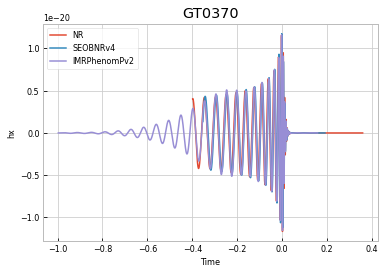

In [16]:
P.figure()
P.plot(t_NR, h_NR.imag, label='NR')
P.plot(t_seob, h_seob.imag, label=waveform_model1)
P.plot(t_ph, h_ph.imag, label=waveform_model2)
#P.xlim(-0.1,0.05)
P.title(waveform)
P.xlabel('Time')
P.ylabel('hx')
P.grid(True)
P.legend()
P.savefig(figdir+'Strain_%s_imag_zoom.png'%waveform)
P.close()
